# Updating the clustering with supervised labels.

In [1]:
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn import metrics
from matplotlib import rcParams
from time import time

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda
from keras.initializers import Initializer
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.engine.topology import Layer
from keras import backend as K

sys.path.insert(0,'../DEC-keras/')
from DEC import DEC, ClusteringLayer, cluster_acc
from datasets import load_mnist

Using TensorFlow backend.
/Users/dwright/anaconda2/envs/aind/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
np.random.seed(0)

In [3]:
batch_size = 256
lr         = 0.01 # learning rate
momentum   = 0.9
tol        = 0.001 # tolerance - if clustering stops if less than this fraction of the data changes cluster on an interation
maxiter         = 2e4
update_interval = 140
save_dir         = '../DEC-keras/results/'

In [4]:
def get_cluster_to_label_mapping(y, y_pred, n_classes, n_clusters):

  one_hot_encoded = np_utils.to_categorical(y, n_classes)

  cluster_to_label_mapping = [] # will be a mapping from the cluster index to the label assigned to that cluster
  n_assigned_list = []
  majority_class_fractions = []
  majority_class_pred = np.zeros(y.shape)
  for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    n_assigned_examples = cluster_indices.shape[0]
    n_assigned_list.append(n_assigned_examples)
    cluster_labels = one_hot_encoded[cluster_indices]
    cluster_label_fractions = np.mean(cluster_labels, axis=0)
    majority_cluster_class = np.argmax(cluster_label_fractions)
    cluster_to_label_mapping.append(majority_cluster_class)
    majority_class_pred[cluster_indices] += majority_cluster_class
    majority_class_fractions.append(cluster_label_fractions[majority_cluster_class])
    print(cluster, n_assigned_examples, majority_cluster_class, cluster_label_fractions[majority_cluster_class])
  print(cluster_to_label_mapping)
  return cluster_to_label_mapping, n_assigned_list, majority_class_fractions

In [5]:
class MapInitializer(Initializer):
    
  def __init__(self, mapping, n_classes):
    self.mapping = mapping
    self.n_classes = n_classes

  def __call__(self, shape, dtype=None):
    return K.one_hot(self.mapping, self.n_classes)
    #return K.ones(shape=(100,10))

  def get_config(self):
    return {'mapping': self.mapping, 'n_classes': self.n_classes}

class MappingLayer(Layer):

  def __init__(self, mapping, output_dim, kernel_initializer, **kwargs):
  #def __init__(self, mapping, output_dim, **kwargs):
    self.output_dim = output_dim
    # mapping is a list where the index corresponds to a cluster and the value is the label.
    # e.g. say mapping[0] = 5, then a label of 5 has been assigned to cluster 0
    self.n_classes = np.unique(mapping).shape[0]      # get the number of classes
    self.mapping = K.variable(mapping, dtype='int32')
    self.kernel_initializer = kernel_initializer
    super(MappingLayer, self).__init__(**kwargs)

  def build(self, input_shape):
  
    self.kernel = self.add_weight(name='kernel', 
                                  shape=(input_shape[1], self.output_dim),
                                  initializer=self.kernel_initializer,
                                  trainable=False)
  
    super(MappingLayer, self).build(input_shape)  # Be sure to call this somewhere!

  def call(self, x):
    # create a matrix of zeros and ones that maps the correct neurons from the clustering layer 
    # to the output neuron corresponding to that cluster's label.
    #mapping = K.one_hot(self.mapping, self.n_classes)
    # sum up the all the soft assignments to clusters with the same labels and calculate the softmax
    # of that sum to produce a probability.
    #return K.softmax(K.dot(x, mapping))
    return K.softmax(K.dot(x, self.kernel))

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)

In [6]:
def build_model(dec, cluster_to_label_mapping, n_classes=10, input_shape=784, 
                ae_weights='../DEC-keras/results/mnist/ae_weights.h5', save_dir='../DEC-keras/results/mnist/10/',
                metrics = ['acc']):
  dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                       ae_weights=ae_weights,
                       x=x)
  dec.load_weights(save_dir+'/DEC_model_final.h5')
  a = Input(shape=(input_shape,)) # input layer
  q = dec.model(a)
  pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes, kernel_initializer=MapInitializer(cluster_to_label_mapping, n_classes))(q)
  model = Model(inputs=a, outputs=pred)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
  return model 

In [278]:
def pca_projection(x, dec, n_components=2):
  assert(n_components in [2,3])
  pca = PCA(n_components=n_components)
  x_pca = pca.fit_transform(dec.extract_feature(x))
  c_pca = pca.transform(dec.model.get_layer(name='clustering').get_weights()[0])
  fig = plt.figure(figsize=(10,10))
  if n_components == 3:
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], marker='o', s=20, color='#747777', alpha=0.6)
    ax.scatter(c_pca[:,0], c_pca[:,1], c_pca[:,2], marker='o', s=20, color='#E06C9F', alpha=1)
  elif n_components == 2:
    ax = fig.add_subplot(111)
    ax.scatter(x_pca[:,0], x_pca[:,1], marker='o', s=20, color='#747777', alpha=0.6)
    ax.scatter(c_pca[:,0], c_pca[:,1], marker='o', s=20, color='#E06C9F', alpha=1)
    plt.axis('off')
  plt.show()
  return x_pca, c_pca, pca

In [12]:
def calculateAccuracy(y, y_pred):
  return 100*np.sum(y_pred == y) / len(y_pred)

In [164]:
def precent_fpr(y_true, y_pred, percent=0.01):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  FoM = 1-tpr[np.where(fpr<=percent)[0][-1]] # MDR at 1% FPR
  return FoM

In [184]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [200]:
def get_cluster_anchor(x, y, dec, cluster_to_label_mapping):
  m_all = np.shape(x)[0]
  cluster_centres = np.squeeze(np.array(dec.model.get_layer(name='clustering').get_weights()))
  x_embedded = dec.extract_feature(x)
  anchors = []
  anchor_indices = []
  for i in range(n_clusters):
    indices_assigned = np.where(y==cluster_to_label_mapping[i])
    m = indices_assigned[0].shape[0]
    #print(i)
    c = np.tile(cluster_centres[i][np.newaxis], (m,1))
    c_all = np.tile(cluster_centres[i][np.newaxis], (m_all,1))
    distances_assigned = np.linalg.norm(x_embedded[indices_assigned] - c, axis=1)
    distances = np.linalg.norm(x_embedded - c_all, axis=1)
    #assert y[np.argmin(distances)] == cluster_to_label_mapping[i]
    #print(y[np.where(distances <= np.min(distances)+.001*np.std(distances))])
    #plt.hist(distances, normed=True)
    #plt.hist(distances_assigned, normed=True)
    #plt.show()
    anchor_indices.append(np.argmin(distances))
    anchors.append(x[np.argmin(distances)])
  return np.array(anchors), np.array(anchor_indices)

## MNIST - 10 clusters

In [14]:
x, y = load_mnist()

MNIST samples (70000, 784)


In [15]:
n_clusters = 10
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
ae_weights = '../DEC-keras/results/mnist/ae_weights.h5'
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x, loss='kld')
dec.load_weights('../DEC-keras/results/mnist/%d/DEC_model_final.h5'%n_clusters)
dec.model.summary()
cluster_centres = dec.model.get_layer(name='clustering').get_weights()[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,665,110.0
Trainable params: 1,665,110.0
Non-trainable params: 0.0
____________________________________________________________

In [20]:
y_pred = dec.predict_clusters(x)

In [21]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y, y_pred, 10, n_clusters=n_clusters)

0 6991 8 0.942783578887
1 6924 0 0.984979780474
2 7227 7 0.969420229694
3 7418 3 0.925721218657
4 6485 4 0.518735543562
5 7717 1 0.989762861215
6 7091 2 0.955436468763
7 6221 5 0.946632374216
8 7252 9 0.505102040816
9 6674 6 0.984866646689
[8, 0, 7, 3, 4, 1, 2, 5, 9, 6]


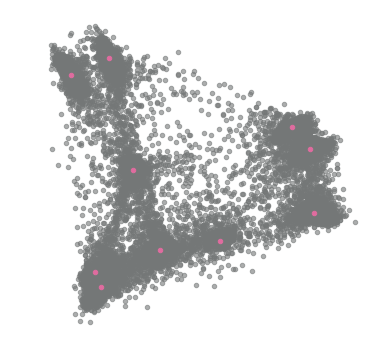

In [22]:
x_pca, c_pca, pca = pca_projection(x, dec)

In [23]:
y_pred = []
for p in dec.predict_clusters(x):
  y_pred.append(cluster_to_label_mapping[p])
y_pred = np.asarray(y_pred)
calculateAccuracy(y, y_pred)

87.408571428571435

In [24]:
model = build_model(dec, cluster_to_label_mapping)

In [25]:
model.fit(x[:700], np_utils.to_categorical(y[:700], 10), epochs=10, batch_size=256)

Epoch 1/10
700/700 [==============================] - 1s - loss: 1.7215 - acc: 0.8686     
Epoch 2/10
700/700 [==============================] - 0s - loss: 1.7141 - acc: 0.8786     
Epoch 3/10
700/700 [==============================] - 0s - loss: 1.6461 - acc: 0.8857     
Epoch 4/10
700/700 [==============================] - 0s - loss: 1.6130 - acc: 0.8914     
Epoc

In [26]:
y_pred = dec.predict_clusters(x)

In [27]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y, y_pred, 10, n_clusters=10)

0 7110 8 0.931364275668
1 6973 0 0.980209379033
2 7243 7 0.968797459616
3 7147 3 0.947530432349
4 9347 4 0.676152776292
5 7706 1 0.98987801713
6 7106 2 0.953278919223
7 6259 5 0.953986259786
8 4312 9 0.861317254174
9 6797 6 0.978667058997
[8, 0, 7, 3, 4, 1, 2, 5, 9, 6]


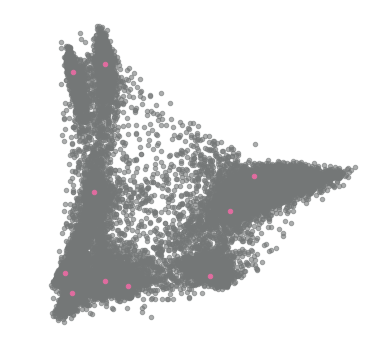

In [28]:
x_pca, c_pca, pca = pca_projection(x, dec)

In [29]:
y_pred = []
for p in dec.predict_clusters(x):
  y_pred.append(cluster_to_label_mapping[p])
y_pred = np.asarray(y_pred)
calculateAccuracy(y, y_pred)

91.864285714285714

## MNIST - 100 clusters

In [30]:
n_clusters = 100
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
ae_weights = '../DEC-keras/results/mnist/ae_weights.h5'
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x, loss='kld')
dec.load_weights('../DEC-keras/results/mnist/%d/DEC_model_final.h5'%n_clusters)
dec.model.summary()
y_pred = dec.predict_clusters(x)
cluster_centres = dec.model.get_layer(name='clustering').get_weights()[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 100)               1000      
Total params: 1,666,010.0
Trainable params: 1,666,010.0
Non-trainable params: 0.0
____________________________________________________________

In [31]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y, y_pred, 10, n_clusters=n_clusters)

0 82 6 0.768292682927
1 1218 1 0.995073891626
2 326 3 0.929447852761
3 923 0 0.98374864572
4 305 7 0.950819672131
5 470 7 0.874468085106
6 1624 4 0.987684729064
7 1325 5 0.972830188679
8 502 3 0.998007968127
9 1566 9 0.915070242656
10 1294 1 0.993044822257
11 1043 0 0.968360498562
12 2049 8 0.971205466081
13 950 6 0.992631578947
14 58 2 0.810344827586
15 258 2 0.848837209302
16 440 3 0.934090909091
17 1888 3 0.969809322034
18 547 4 0.946983546618
19 30 2 0.966666666667
20 984 7 0.983739837398
21 426 0 0.99765258216
22 326 5 0.858895705521
23 9 6 0.333333333333
24 404 0 0.925742574257
25 528 5 0.922348484848
26 1096 5 0.984489051095
27 1322 0 0.983358547655
28 2592 8 0.947916666667
29 56 3 0.839285714286
30 895 1 0.964245810056
31 1306 8 0.981623277182
32 899 6 0.982202447164
33 642 9 0.964174454829
34 2389 3 0.984930933445
35 15 8 0.866666666667
36 1370 6 0.989781021898
37 485 9 0.898969072165
38 1001 1 0.998001998002
39 3 8 1.0
40 1432 1 0.980446927374
41 35 2 0.571428571429
42 33 4 0

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


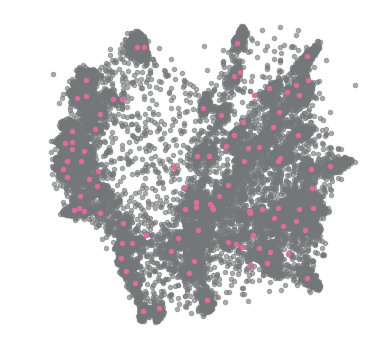

In [32]:
x_pca, c_pca, pca = pca_projection(x, dec)

In [33]:
y_pred = []
for p in dec.predict_clusters(x):
  y_pred.append(cluster_to_label_mapping[p])
y_pred = np.asarray(y_pred)
calculateAccuracy(y, y_pred)

96.484285714285718

In [34]:
model = build_model(dec, cluster_to_label_mapping, save_dir='../DEC-keras/results/mnist/100/')

In [35]:
model.fit(x[:7000], np_utils.to_categorical(y[:7000], 10), epochs=50, batch_size=256)

Epoch 1/50
7000/7000 [==============================] - 5s - loss: 1.7266 - acc: 0.9710      

In [36]:
y_pred = dec.predict_clusters(x)

In [37]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y, y_pred, 10, n_clusters=100)

0 65 6 0.892307692308
1 1249 1 0.993594875901
2 343 3 0.868804664723
3 922 0 0.991323210412
4 256 7 0.96484375
5 487 7 0.889117043121
6 1803 4 0.988352745424
7 1296 5 0.984567901235
8 523 3 0.994263862333
9 1370 9 0.950364963504
10 1207 1 0.991714995857
11 1068 0 0.974719101124
12 2135 8 0.969555035129
13 948 6 0.993670886076
14 66 2 0.833333333333
15 224 2 0.888392857143
16 462 3 0.924242424242
17 1892 3 0.974101479915
18 591 4 0.954314720812
19 17 2 0.941176470588
20 973 7 0.98766700925
21 429 0 0.997668997669
22 310 5 0.858064516129
23 1 6 1.0
24 393 0 0.936386768448
25 497 5 0.953722334004
26 1101 5 0.985467756585
27 1288 0 0.976708074534
28 2557 8 0.964020336332
29 36 3 0.777777777778
30 900 1 0.972222222222
31 1299 8 0.986913010008
32 899 6 0.992213570634
33 636 9 0.968553459119
34 2474 3 0.98181083266
35 4 8 0.75
36 1392 6 0.994252873563
37 440 9 0.954545454545
38 1024 1 0.998046875
39 0 0 nan
40 1404 1 0.988603988604
41 22 2 0.5
42 19 4 0.789473684211
43 2 8 1.0
44 2 8 1.0
45 5

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


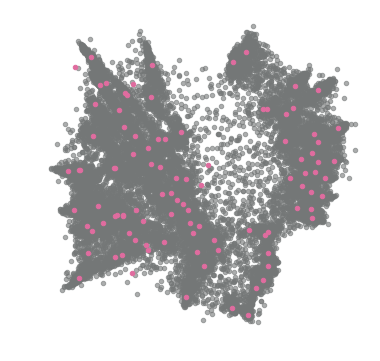

In [38]:
x_pca, c_pca, pca = pca_projection(x, dec)

In [39]:
y_pred = []
for p in dec.predict_clusters(x):
  y_pred.append(cluster_to_label_mapping[p])
y_pred = np.asarray(y_pred)
calculateAccuracy(y, y_pred)

97.121428571428567

## SNHunters - 10 clusters

In [40]:
data = sio.loadmat('../data/3pi_20x20_skew2_signPreserveNorm.mat')
x = np.concatenate((data['X'], data['testX']))
y = np.squeeze(np.concatenate((data['y'], data['testy'])))
x_train = data['X']
x_test  = data['testX']
y_train = np.squeeze(data['y'])
y_test  = np.squeeze(data['testy'])

In [41]:
n_clusters = 10
dec_snh = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
dec_snh.initialize_model(optimizer=SGD(lr=0.01, momentum=momentum),
                            ae_weights='../DEC-keras/results/snh/%d/ae_weights_snh.h5'%n_clusters, 
                            x=x, loss='kld')
save_dir = '../DEC-keras/results/snh/%d'%n_clusters
try:
  dec_snh.load_weights(save_dir+'/DEC_model_final.h5')
  y_pred = dec_snh.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec_snh.clustering(x, y=y, tol=tol, maxiter=maxiter,
                              update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
dec_snh.model.summary()
y_pred = dec_snh.predict_clusters(x_train)
cluster_centres = dec_snh.model.get_layer(name='clustering').get_weights()[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               200500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,473,110.0
Trainable params: 1,473,110.0
Non-trainable params: 0.0
____________________________________________________________

In [42]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y_train, y_pred, 2, n_clusters=n_clusters)

0 117 0 1.0
1 328 0 0.69512195122
2 710 0 0.705633802817
3 1069 0 0.703461178672
4 365 0 0.572602739726
5 1673 0 0.563060370592
6 1460 0 0.790410958904
7 690 0 0.58115942029
8 2 0 1.0
9 502 0 0.603585657371
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


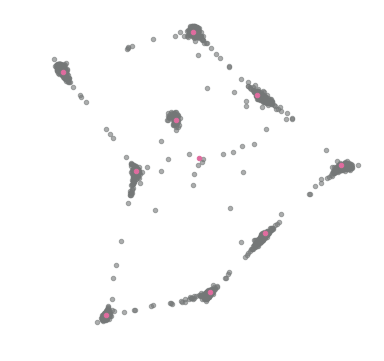

In [43]:
x_pca, c_pca, pca = pca_projection(x_train, dec_snh)

In [44]:
y_pred = []
for p in dec_snh.predict_clusters(x_train):
  y_pred.append(cluster_to_label_mapping[p])
y_pred = np.asarray(y_pred)
print(calculateAccuracy(y_train, y_pred))
print(calculateAccuracy(y_train, np.zeros(y_train.shape))) # all zeros benchmark

66.6425679584
66.6425679584


No cluster is assigned a majority class of 1 (real). This is a problem because the mappig layer will not link any nodes in the clustering layer to the "real" node in the mapping layer.  Either assign the most confused cluster to a label of 1 or use more clusters to try and ensure at least one cluster is majority real.

### most confused cluster reassignment.

In [45]:
print(cluster_to_label_mapping)
cluster_to_label_mapping[5] = 1
print(cluster_to_label_mapping)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [46]:
model = build_model(dec_snh, cluster_to_label_mapping, input_shape=400, n_classes=2,
                ae_weights='../DEC-keras/results/snh/ae_weights_snh.h5', save_dir='../DEC-keras/results/snh/10/')

In [47]:
precent_fpr(y_test, model.predict(x_test)[:,1])

0.92297650130548303

In [48]:
model.fit(x_train, np_utils.to_categorical(y_train, 2), epochs=50, batch_size=256)

Epoch 1/50
6916/6916 [==============================] - 3s - loss: 0.5874 - acc: 0.7102      

In [49]:
y_pred = dec_snh.predict_clusters(x)

In [50]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y, y_pred, 2, n_clusters=n_clusters)

0 0 0 nan
1 0 0 nan
2 0 0 nan
3 3 1 1.0
4 5620 0 0.99359430605
5 3277 1 0.915471467806
6 0 0 nan
7 1 0 1.0
8 0 0 nan
9 318 0 0.893081761006
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


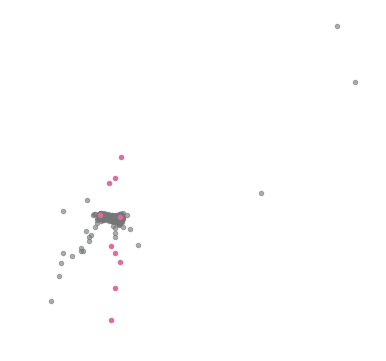

In [51]:
x_pca, c_pca, pca = pca_projection(x, dec_snh)

In [52]:
y_pred = []
for p in dec_snh.predict_clusters(x_test):
  y_pred.append(cluster_to_label_mapping[p])
y_pred = np.asarray(y_pred)
print(calculateAccuracy(y_test, y_pred))

88.7103777681


In [53]:
precent_fpr(y_test, model.predict(x_test)[:,1])

0.72845953002610964

## SNHunters - 100 clusters

In [110]:
n_clusters = 100
dec_snh = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
dec_snh.initialize_model(optimizer=SGD(lr=0.01, momentum=momentum),
                            ae_weights='../DEC-keras/results/snh/%d/ae_weights_snh.h5'%n_clusters, 
                            x=x, loss='kld')
save_dir = '../DEC-keras/results/snh/%d'%n_clusters
try:
  dec_snh.load_weights(save_dir+'/DEC_model_final.h5')
  y_pred = dec_snh.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec_snh.clustering(x, y=y, tol=tol, maxiter=maxiter,
                              update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
dec_snh.model.summary()
y_pred = dec_snh.predict_clusters(x_train)
cluster_centres = dec_snh.model.get_layer(name='clustering').get_weights()[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               200500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 100)               1000      
Total params: 1,474,010.0
Trainable params: 1,474,010.0
Non-trainable params: 0.0
____________________________________________________________

In [111]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y_train, y_pred, 2, n_clusters=n_clusters)

0 0 0 nan
1 80 0 0.8
2 0 0 nan
3 0 0 nan
4 0 0 nan
5 0 0 nan
6 0 0 nan
7 209 0 0.555023923445
8 0 0 nan
9 0 0 nan
10 219 0 0.611872146119
11 46 0 0.54347826087
12 0 0 nan
13 180 0 0.6
14 58 0 0.637931034483
15 37 0 0.810810810811
16 1 0 1.0
17 39 0 0.538461538462
18 88 0 0.670454545455
19 0 0 nan
20 0 0 nan
21 0 0 nan
22 1 0 1.0
23 0 0 nan
24 0 0 nan
25 0 0 nan
26 14 1 0.714285714286
27 0 0 nan
28 8 0 1.0
29 80 0 0.6
30 0 0 nan
31 0 0 nan
32 57 0 0.631578947368
33 0 0 nan
34 0 0 nan
35 0 0 nan
36 0 0 nan
37 0 0 nan
38 0 0 nan
39 0 0 nan
40 47 0 0.659574468085
41 0 0 nan
42 19 0 0.578947368421
43 0 0 nan
44 212 0 0.603773584906
45 0 0 nan
46 0 0 nan
47 0 0 nan
48 43 0 0.720930232558
49 0 0 nan
50 0 0 nan
51 65 0 0.6
52 0 0 nan
53 0 0 nan
54 237 0 0.628691983122
55 807 0 0.640644361834
56 0 0 nan
57 0 0 nan
58 35 0 0.6
59 0 0 nan
60 1 0 1.0
61 1276 0 0.612068965517
62 0 0 nan
63 20 0 0.8
64 15 0 0.533333333333
65 0 0 nan
66 0 0 nan
67 0 0 nan
68 0 0 nan
69 46 0 0.630434782609
70 0 0 nan


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


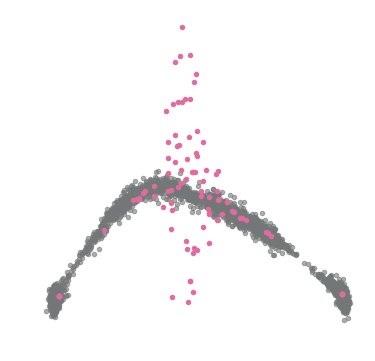

In [112]:
x_pca, c_pca, pca = pca_projection(x_train, dec_snh)

In [113]:
y_pred = []
for p in dec_snh.predict_clusters(x_train):
  y_pred.append(cluster_to_label_mapping[p])
y_pred = np.asarray(y_pred)
calculateAccuracy(y_train, y_pred)

66.729323308270679

In [114]:
model = build_model(dec_snh, cluster_to_label_mapping, input_shape=400, n_classes=2,
                ae_weights='../DEC-keras/results/snh/ae_weights_snh.h5', save_dir='../DEC-keras/results/snh/100/')

In [115]:
model.fit(x_train, np_utils.to_categorical(y_train, 2), epochs=50, batch_size=256)

Epoch 1/50
6916/6916 [==============================] - 3s - loss: 0.6343 - acc: 0.6664      

In [116]:
y_pred = dec_snh.predict_clusters(x_train)

In [117]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y_train, y_pred, 2, n_clusters=n_clusters)

0 0 0 nan
1 59 0 1.0
2 0 0 nan
3 19 0 1.0
4 1 0 1.0
5 57 0 1.0
6 0 0 nan
7 0 0 nan
8 10 0 1.0
9 0 0 nan
10 19 0 1.0
11 4 0 1.0
12 0 0 nan
13 51 0 1.0
14 209 0 0.995215311005
15 107 0 0.990654205607
16 0 0 nan
17 32 0 1.0
18 284 0 0.996478873239
19 0 0 nan
20 0 0 nan
21 84 0 1.0
22 0 0 nan
23 0 0 nan
24 0 0 nan
25 0 0 nan
26 2417 1 0.950351675631
27 0 0 nan
28 49 0 1.0
29 11 0 1.0
30 10 0 1.0
31 0 0 nan
32 61 0 1.0
33 282 0 0.996453900709
34 1 0 1.0
35 0 0 nan
36 0 0 nan
37 11 0 1.0
38 0 0 nan
39 0 0 nan
40 11 0 1.0
41 0 0 nan
42 8 0 1.0
43 0 0 nan
44 336 0 1.0
45 0 0 nan
46 9 0 1.0
47 5 0 1.0
48 4 0 1.0
49 0 0 nan
50 0 0 nan
51 3 0 1.0
52 0 0 nan
53 1 0 1.0
54 410 0 1.0
55 40 0 1.0
56 1 0 1.0
57 0 0 nan
58 22 0 1.0
59 28 0 1.0
60 63 0 1.0
61 36 0 0.972222222222
62 0 0 nan
63 21 0 1.0
64 13 0 1.0
65 1 0 1.0
66 0 0 nan
67 0 0 nan
68 0 0 nan
69 5 0 1.0
70 41 0 1.0
71 7 0 1.0
72 10 0 1.0
73 0 0 nan
74 204 0 1.0
75 0 0 nan
76 0 0 nan
77 97 0 1.0
78 56 0 1.0
79 0 0 nan
80 44 0 0.909090909091

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


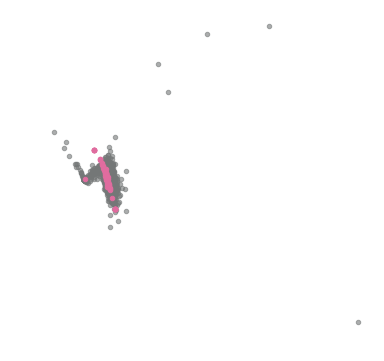

In [118]:
x_pca, c_pca, pca = pca_projection(x_train, dec_snh)

In [119]:
y_pred = []
for p in dec_snh.predict_clusters(x_test):
  y_pred.append(cluster_to_label_mapping[p])
y_pred = np.asarray(y_pred)
calculateAccuracy(y_test, y_pred)

89.188015631784623

In [120]:
precent_fpr(y_test, model.predict(x_test)[:,1])

0.71409921671018273

# Reclustering

In [150]:
n_clusters = 100
redec_snh = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
redec_snh.initialize_model(optimizer=SGD(lr=0.01, momentum=momentum),
                            ae_weights='../DEC-keras/results/snh/%d/ae_weights_snh.h5'%n_clusters, 
                            x=x, loss='kld')
save_dir = '../DEC-keras/results/snh/%d'%n_clusters
try:
  redec_snh.load_weights(save_dir+'/DEC_model_final.h5')
  y_pred = redec_snh.predict_clusters(x_train)
except IOError:
  t0 = time()
  y_pred = redec_snh.clustering(x, y=y, tol=tol, maxiter=maxiter,
                              update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
redec_snh.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               200500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 100)               1000      
Total params: 1,474,010.0
Trainable params: 1,474,010.0
Non-trainable params: 0.0
____________________________________________________________

In [152]:
for i,l in enumerate(dec_snh.encoder.layers):
  w = l.get_weights()
  redec_snh.encoder.layers[i].set_weights(w)

# prepare DEC model
redec_snh.model.compile(loss='kld', optimizer=SGD(lr=0.01, momentum=0.9))
redec_snh.model.get_layer(name='clustering').set_weights([dec_snh.model.get_layer(name='clustering').get_weights()[0]])
redec_snh.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               200500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 100)               1000      
Total params: 1,474,010.0
Trainable params: 1,474,010.0
Non-trainable params: 0.0
____________________________________________________________

In [153]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y_train, y_pred, 2, n_clusters=n_clusters)

0 0 0 nan
1 80 0 0.8
2 0 0 nan
3 0 0 nan
4 0 0 nan
5 0 0 nan
6 0 0 nan
7 209 0 0.555023923445
8 0 0 nan
9 0 0 nan
10 219 0 0.611872146119
11 46 0 0.54347826087
12 0 0 nan
13 180 0 0.6
14 58 0 0.637931034483
15 37 0 0.810810810811
16 1 0 1.0
17 39 0 0.538461538462
18 88 0 0.670454545455
19 0 0 nan
20 0 0 nan
21 0 0 nan
22 1 0 1.0
23 0 0 nan
24 0 0 nan
25 0 0 nan
26 14 1 0.714285714286
27 0 0 nan
28 8 0 1.0
29 80 0 0.6
30 0 0 nan
31 0 0 nan
32 57 0 0.631578947368
33 0 0 nan
34 0 0 nan
35 0 0 nan
36 0 0 nan
37 0 0 nan
38 0 0 nan
39 0 0 nan
40 47 0 0.659574468085
41 0 0 nan
42 19 0 0.578947368421
43 0 0 nan
44 212 0 0.603773584906
45 0 0 nan
46 0 0 nan
47 0 0 nan
48 43 0 0.720930232558
49 0 0 nan
50 0 0 nan
51 65 0 0.6
52 0 0 nan
53 0 0 nan
54 237 0 0.628691983122
55 807 0 0.640644361834
56 0 0 nan
57 0 0 nan
58 35 0 0.6
59 0 0 nan
60 1 0 1.0
61 1276 0 0.612068965517
62 0 0 nan
63 20 0 0.8
64 15 0 0.533333333333
65 0 0 nan
66 0 0 nan
67 0 0 nan
68 0 0 nan
69 46 0 0.630434782609
70 0 0 nan


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [154]:
save_dir = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/tmp/re100'
save_interval = 1400
loss = 0
index = 0
y_pred = redec_snh.predict_clusters(x)
y_pred_last = y_pred
for ite in range(int(maxiter)):
  if ite % update_interval == 0:
    q = redec_snh.model.predict(x, verbose=0)
    p = redec_snh.target_distribution(q)  # update the auxiliary target distribution p
    # evaluate the clustering performance
    y_pred = q.argmax(1)
    delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
    y_pred_last = y_pred
    if y is not None:
      acc = np.round(cluster_acc(y, y_pred), 5)
      nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
      ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
      loss = np.round(loss, 5)
      print('Iter', ite, ': Acc', acc, ', nmi', nmi, ', ari', ari, '; loss=', loss)
    # check stop criterion
    if ite > 0 and delta_label < tol:
      print('delta_label ', delta_label, '< tol ', tol)
      print('Reached tolerance threshold. Stopping training.')
      break
    # train on batch
  if (index + 1) * redec_snh.batch_size > x.shape[0]:
    loss = redec_snh.model.train_on_batch(x=x[index * redec_snh.batch_size::],
                                          y=p[index * redec_snh.batch_size::])
    index = 0
  else:
    loss = redec_snh.model.train_on_batch(x=x[index * redec_snh.batch_size:(index + 1) * redec_snh.batch_size],
                                          y=p[index * redec_snh.batch_size:(index + 1) * redec_snh.batch_size])
    index += 1

  if ite % save_interval == 0:
    # save IDEC model checkpoints
    print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
    redec_snh.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')
  ite += 1

Iter 0 : Acc 0.379 , nmi 0.36699 , ari 0.16479 ; loss= 0
saving model to: /Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/tmp/re100/DEC_model_0.h5
Iter 140 : Acc 0.41349 , nmi 0.3586 , ari 0.15845 ; loss= 0.40533
Iter 280 : Acc 0.38996 , nmi 0.34641 , ari 0.14574 ; loss= 0.16526
Iter 420 : Acc 0.38714 , nmi 0.3341 , ari 0.13225 ; loss= 0.30517
Iter 560 : Acc 0.39354 , nmi 0.33419 , ari 0.13615 ; loss= 0.21321
Iter 700 : Acc 0.38714 , nmi 0.34231 , ari 0.14564 ; loss= 0.22946
Iter 840 : Acc 0.37195 , nmi 0.34182 , ari 0.14467 ; loss= 0.28782
Iter 980 : Acc 0.41913 , nmi 0.34691 , ari 0.15438 ; loss= 0.34913
Iter 1120 : Acc 0.59529 , nmi 0.36273 , ari 0.24397 ; loss= 0.93675
Iter 1260 : Acc 0.57544 , nmi 0.35317 , ari 0.21574 ; loss= 0.21065
Iter 1400 : Acc 0.60668 , nmi 0.37064 , ari 0.24486 ; loss= 0.30741
saving model to: /Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/tmp/re100/DEC_model_1400.h5
Iter 1540 : Acc 0.6236 , nmi 

In [155]:
y_pred = redec_snh.predict_clusters(x_train)

In [156]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y_train, y_pred, 2, n_clusters=n_clusters)

0 0 0 nan
1 1535 0 0.997394136808
2 0 0 nan
3 0 0 nan
4 0 0 nan
5 9 0 1.0
6 0 0 nan
7 1220 0 0.961475409836
8 0 0 nan
9 0 0 nan
10 107 0 0.990654205607
11 0 0 nan
12 0 0 nan
13 318 0 0.987421383648
14 0 0 nan
15 3 0 1.0
16 275 0 1.0
17 10 0 1.0
18 0 0 nan
19 0 0 nan
20 0 0 nan
21 0 0 nan
22 6 0 1.0
23 0 0 nan
24 0 0 nan
25 0 0 nan
26 2492 1 0.901685393258
27 0 0 nan
28 5 0 1.0
29 5 0 1.0
30 0 0 nan
31 0 0 nan
32 0 0 nan
33 0 0 nan
34 0 0 nan
35 46 0 0.978260869565
36 0 0 nan
37 0 0 nan
38 0 0 nan
39 0 0 nan
40 12 0 1.0
41 0 0 nan
42 23 0 1.0
43 3 0 1.0
44 70 0 0.985714285714
45 103 0 1.0
46 0 0 nan
47 0 0 nan
48 19 0 1.0
49 0 0 nan
50 0 0 nan
51 0 0 nan
52 0 0 nan
53 0 0 nan
54 7 0 1.0
55 16 0 0.875
56 0 0 nan
57 0 0 nan
58 0 0 nan
59 0 0 nan
60 2 0 1.0
61 0 0 nan
62 0 0 nan
63 7 0 1.0
64 0 0 nan
65 0 0 nan
66 0 0 nan
67 0 0 nan
68 0 0 nan
69 38 0 1.0
70 0 0 nan
71 0 0 nan
72 0 0 nan
73 0 0 nan
74 34 0 1.0
75 0 0 nan
76 0 0 nan
77 94 0 1.0
78 18 0 1.0
79 0 0 nan
80 6 0 1.0
81 27 0 1.0


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


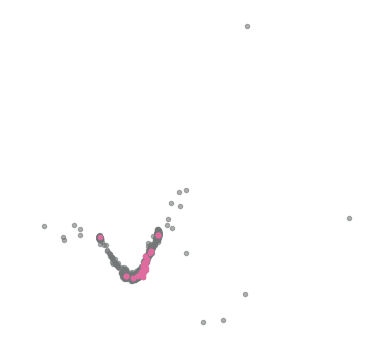

In [158]:
x_pca, c_pca, pca = pca_projection(x_train, redec_snh)

In [159]:
y_pred = []
print(cluster_to_label_mapping)
for p in redec_snh.predict_clusters(x_train):
  y_pred.append(cluster_to_label_mapping[p])
y_pred = np.asarray(y_pred)
calculateAccuracy(y_train, y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


95.589936379410062

In [171]:
a = Input(shape=(400,)) # input layer
q = redec_snh.model(a)
pred = MappingLayer(cluster_to_label_mapping, output_dim=2, kernel_initializer=MapInitializer(cluster_to_label_mapping, 2))(q)
model = Model(inputs=a, outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [173]:
precent_fpr(y_test, model.predict(x_test)[:,1])

0.96344647519582249

In [174]:
precent_fpr(y_test, model.predict(x_test)[:,1], 0.05)

0.51697127937336806

In [176]:
precent_fpr(y_test, model.predict(x_test)[:,1], 0.1)

0.12793733681462138

## Siamese network approach - SNHunters 10 clusters

In [395]:
data = sio.loadmat('../data/3pi_20x20_skew2_signPreserveNorm.mat')
x = np.concatenate((data['X'], data['testX']))
y = np.squeeze(np.concatenate((data['y'], data['testy'])))
x_train = data['X']
x_test  = data['testX']
y_train = np.squeeze(data['y'])
y_test  = np.squeeze(data['testy'])

In [396]:
n_clusters = 10
dec_snh = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
dec_snh.initialize_model(optimizer=SGD(lr=0.01, momentum=momentum),
                            ae_weights='../DEC-keras/results/snh/%d/ae_weights_snh.h5'%n_clusters, 
                            x=x, loss='kld')
save_dir = '../DEC-keras/results/snh/%d'%n_clusters
try:
  dec_snh.load_weights(save_dir+'/DEC_model_final.h5')
  y_pred = dec_snh.predict_clusters(x)
except IOError:
  t0 = time()
  y_pred = dec_snh.clustering(x, y=y, tol=tol, maxiter=maxiter,
                              update_interval=update_interval, save_dir=save_dir)
  print('clustering time: ', (time() - t0))
dec_snh.model.summary()
y_pred = dec_snh.predict_clusters(x_train)
cluster_centres = dec_snh.model.get_layer(name='clustering').get_weights()[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               200500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,473,110.0
Trainable params: 1,473,110.0
Non-trainable params: 0.0
____________________________________________________________

In [397]:
cluster_to_label_mapping, n_assigned_list, majority_class_fractions_orig = \
  get_cluster_to_label_mapping(y_train, y_pred, 2, n_clusters=n_clusters)

0 117 0 1.0
1 328 0 0.69512195122
2 710 0 0.705633802817
3 1069 0 0.703461178672
4 365 0 0.572602739726
5 1673 0 0.563060370592
6 1460 0 0.790410958904
7 690 0 0.58115942029
8 2 0 1.0
9 502 0 0.603585657371
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


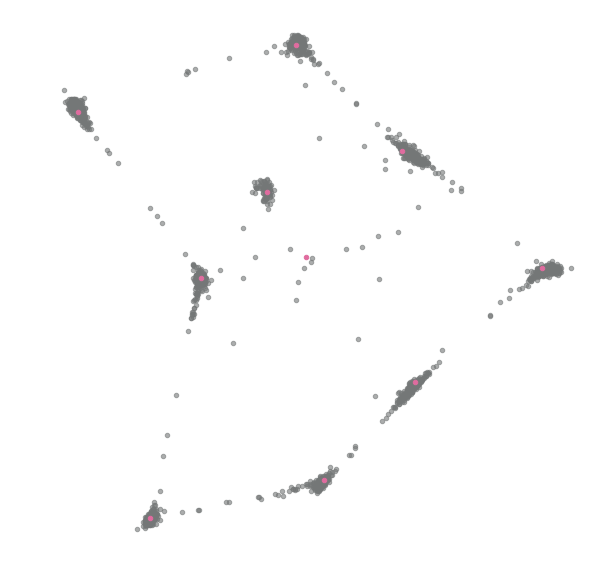

In [398]:
x_pca, c_pca, pca = pca_projection(x_train, dec_snh)

In [399]:
anchors, anchor_indices = get_cluster_anchor(x, y, dec_snh, cluster_to_label_mapping)

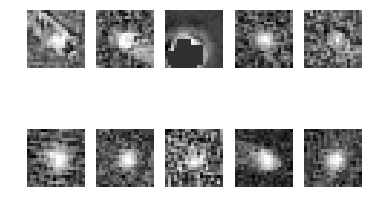

In [400]:
fig = plt.figure()
for i,a in enumerate(anchors):
  ax = fig.add_subplot(2,5,i+1)
  ax.imshow(np.reshape(a, (20,20), order='F'), cmap='gray')
  plt.axis('off')
plt.show()

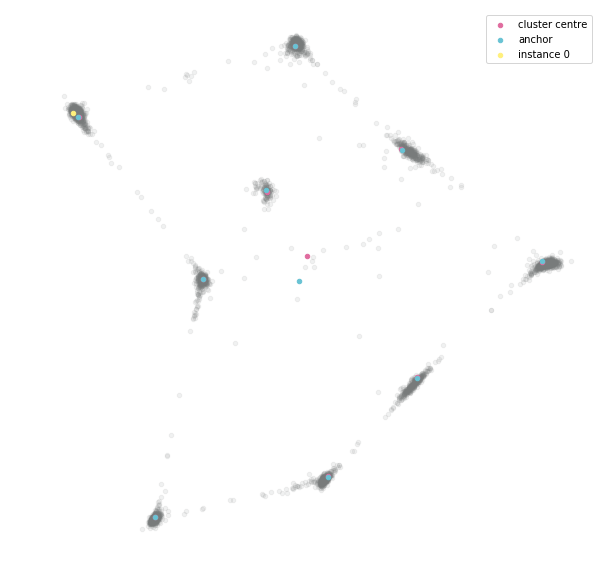

In [401]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(dec_snh.extract_feature(x))
c_pca = pca.transform(dec_snh.model.get_layer(name='clustering').get_weights()[0])
a_pca = pca.transform(dec_snh.extract_feature(anchors))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(x_pca[:,0], x_pca[:,1], marker='o', s=20, color='#747777', alpha=0.1)
ax.scatter(c_pca[:,0], c_pca[:,1], marker='o', s=20, color='#E06C9F', alpha=1.0, label='cluster centre')
ax.scatter(a_pca[:,0], a_pca[:,1], marker='o', s=20, color='#68C3D4', alpha=1.0, label='anchor')
ax.scatter(x_pca[0,0], x_pca[0,1], marker='o', s=20, color='#FFF07C', alpha=1.0, label='instance 0')
plt.axis('off')
plt.legend()
plt.show()

In [402]:
cluster = dec_snh.predict_clusters(x[0][np.newaxis])[0]

In [403]:
pairs = np.array([[x[0], anchors[cluster]]])
labels = np.array([1])

In [404]:
distance = np.linalg.norm(x_pca[0] - c_pca[cluster])
print(distance)

0.311546


In [405]:
base_network = Model(dec_snh.model.input, dec_snh.model.get_layer('encoder_%d' % (dec.n_stacks - 1)).output)

In [406]:
input_dim = x.shape[1]
input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))
processed_a = base_network(input_a)
processed_b = base_network(input_b)

In [407]:
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])
sigmoid = Dense(1, activation='sigmoid')(distance)
model = Model([input_a, input_b], sigmoid)

In [408]:
sgd = SGD(lr=1e-3)
model.compile(loss='binary_crossentropy', optimizer=sgd)
model.fit([pairs[:, 0], pairs[:, 1]], labels, batch_size=1, epochs=5)

Epoch 1/5
1/1 [==============================] - 0s - loss: 0.7072
Epoch 2/5
1/1 [==============================] - 0s - loss: 0.7042
Epoch 3/5
1/1 [==============================] - 0s - loss: 0.7012
Epoch 4/5
1/1 [==============================] - 0s - loss: 0.6983
Epoch 5/5
1/1 [==============================] - 0s - loss: 0.6957


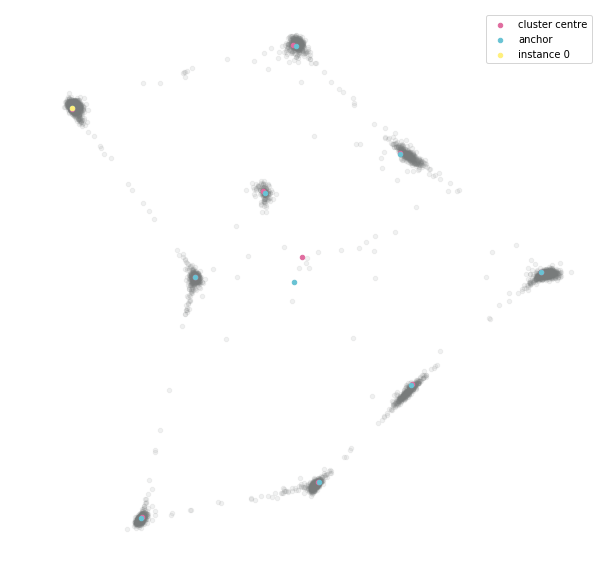

In [409]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(dec_snh.extract_feature(x))
c_pca = pca.transform(dec_snh.model.get_layer(name='clustering').get_weights()[0])
a_pca = pca.transform(dec_snh.extract_feature(anchors))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(x_pca[:,0], x_pca[:,1], marker='o', s=20, color='#747777', alpha=0.1)
ax.scatter(c_pca[:,0], c_pca[:,1], marker='o', s=20, color='#E06C9F', alpha=1.0, label='cluster centre')
ax.scatter(a_pca[:,0], a_pca[:,1], marker='o', s=20, color='#68C3D4', alpha=1.0, label='anchor')
ax.scatter(x_pca[0,0], x_pca[0,1], marker='o', s=20, color='#FFF07C', alpha=1.0, label='instance 0')
plt.axis('off')
plt.legend()
plt.show()

In [410]:
distance = np.linalg.norm(x_pca[0] - c_pca[cluster])
print(distance)

0.0282855
